In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

In [3]:
# Import OpenSense modules as submodules
import sys
import os

sys.path.append(os.path.abspath("./pycomlink/"))
sys.path.append(os.path.abspath("./poligrain/src/"))
sys.path.append(os.path.abspath("./mergeplg/src/"))

import pycomlink as pycml 
import poligrain as plg

# OpenMRG analysis
OPEN FILES

In [4]:
dataset = 'OpenMRG'
adj_path = 'data/adjusted_fields/'

ds_gauges = xr.open_dataset('data/andersson_2022_OpenMRG/gauges/openmrg_gauges.nc')     
ds_rad = xr.open_dataset("data/andersson_2022_OpenMRG/radar/openmrg_rad.nc")          
ds_cmls = xr.open_dataset("data/processed_cml_OpenMRG.nc").R_acc                              

# adding adjusted field and naming
ds_rad = ds_rad.rename({'rainfall_amount':'rainfall_radar'})  
ds_rad['rainfall_add_IDW']=xr.open_dataset(adj_path+dataset+'_rainfall_add_IDW.nc').rainfall_add_IDW
ds_rad['rainfall_add_pBK']=xr.open_dataset(adj_path+dataset+'_rainfall_add_pBK.nc').rainfall_add_pBK
ds_rad['rainfall_add_lBK']=xr.open_dataset(adj_path+dataset+'_rainfall_add_lBK.nc').rainfall_add_lBK
ds_rad['rainfall_mul_IDW']=xr.open_dataset(adj_path+dataset+'_rainfall_mul_IDW.nc').rainfall_mul_IDW
ds_rad['rainfall_mul_pBK']=xr.open_dataset(adj_path+dataset+'_rainfall_mul_pBK.nc').rainfall_mul_pBK
ds_rad['rainfall_mul_lBK']=xr.open_dataset(adj_path+dataset+'_rainfall_mul_lBK.nc').rainfall_mul_lBK
ds_rad['rainfall_pked']=xr.open_dataset(adj_path+dataset+'_rainfall_pked.nc').rainfall_ked
ds_rad['rainfall_lked']=xr.open_dataset(adj_path+dataset+'_rainfall_lked.nc').rainfall_ked

COMPARE RADAR AND RAIN GAUGES

In [5]:
# fields = [[gauge name, radar name]]
fields = ['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 
          'rainfall_add_lBK', 'rainfall_pked', 'rainfall_lked',
          'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']

get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.isel(time = 0), 
    da_point_data=ds_gauges.isel(time = 0),
    nnear=1,
    stat="best" 
)

for field in fields:
    ds_gauges[field] = get_grid_at_points(
        da_gridded_data=ds_rad[field],
        da_point_data=ds_gauges.rainfall_amount,  
    )

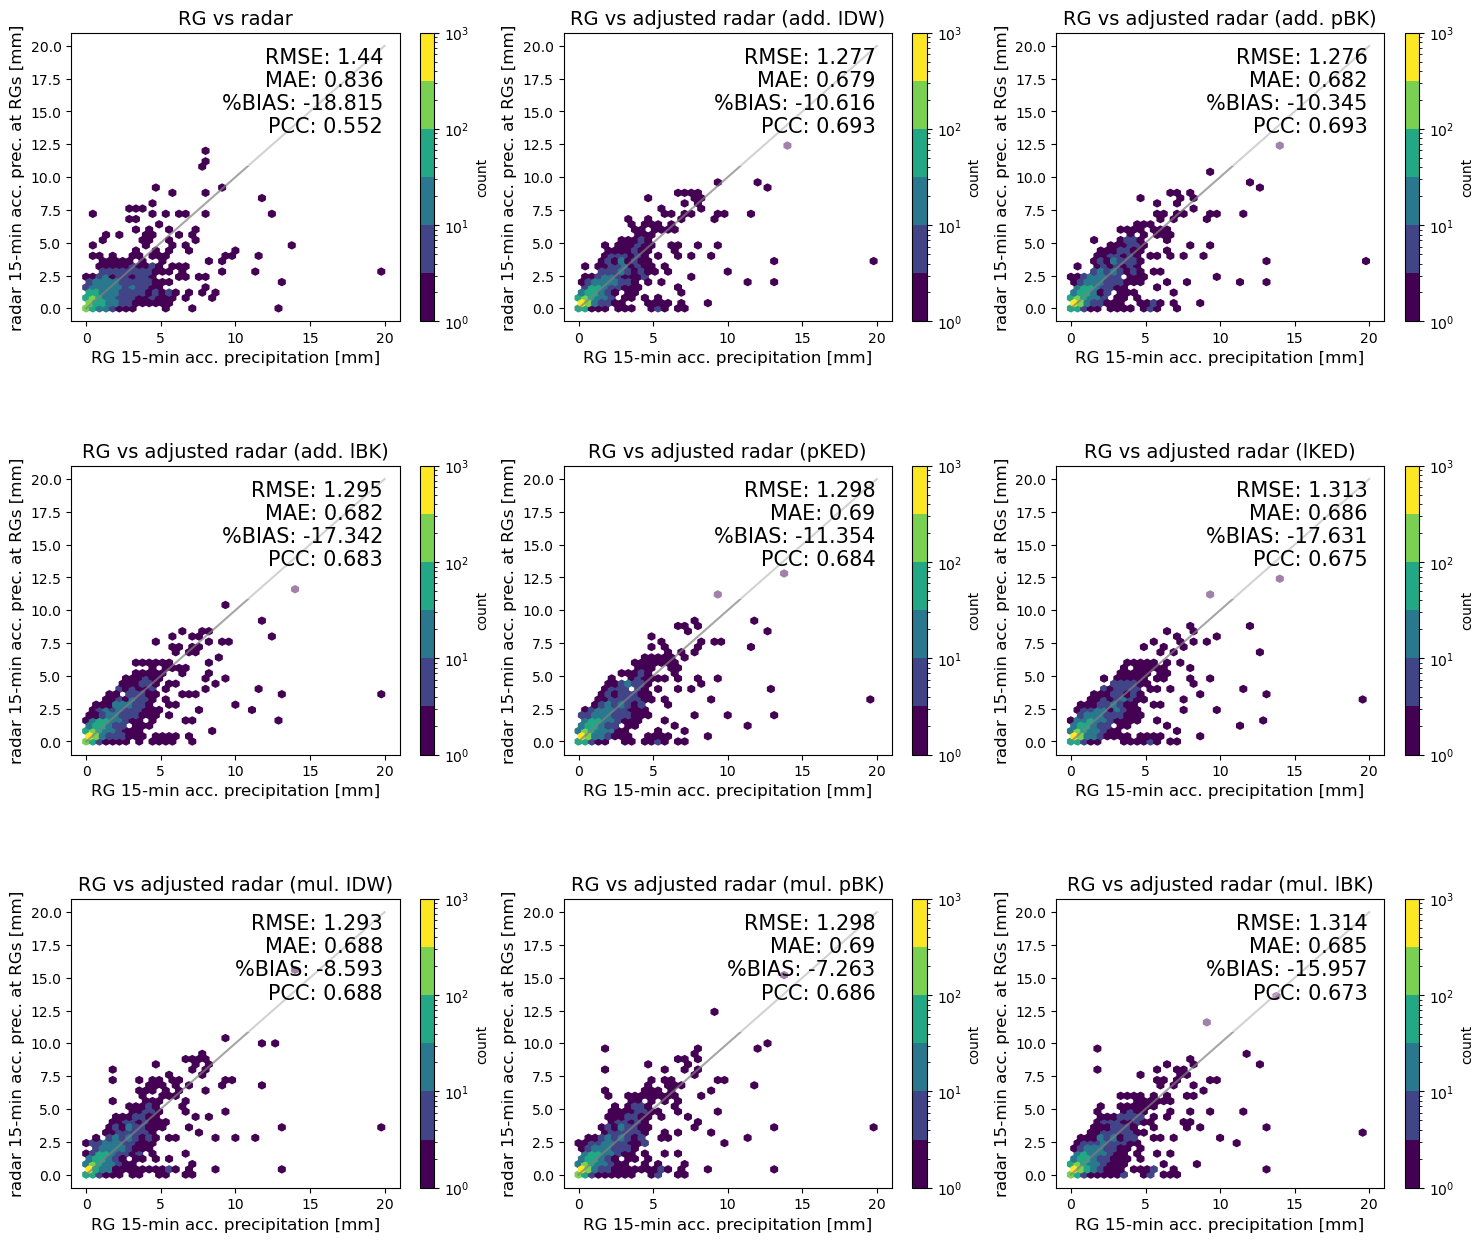

In [6]:
# fields = [[gauge name, title]]
fields = [['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK'],
          ['rainfall_add_lBK', 'rainfall_pked', 'rainfall_lked'],
          ['rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']]

titles = [['RG vs radar', 'RG vs adjusted radar (add. IDW)', 'RG vs adjusted radar (add. pBK)'],
          ['RG vs adjusted radar (add. lBK)', 'RG vs adjusted radar (pKED)', 'RG vs adjusted radar (lKED)'],
          ['RG vs adjusted radar (mul. IDW)', 'RG vs adjusted radar (mul. pBK)', 'RG vs adjusted radar (mul. lBK)']]

threshold = 0.2

fig, ax = plt.subplots(3, len(fields[0]), figsize=(6*len(fields[0]), 15)) 

for i in range(0,3):
    for j in range(0,3):

        hx = plg.validation.plot_hexbin(
            ds_gauges.rainfall_amount.values.flatten(),
            ds_gauges[fields[i][j]].values.flatten(),
            ref_thresh=0.1,
            est_thresh=0.1,
            ax=ax[i, j],
        )

        metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
            reference=ds_gauges.rainfall_amount.values.flatten(),
            estimate=ds_gauges[fields[i][j]].values.flatten(),
            ref_thresh=threshold,
            est_thresh=threshold)])

        ax[i, j].text(
            0.95, 0.95,                 
            "RMSE: "+str(round(metric.root_mean_square_error.values[0], 3))+'\n'+
            "MAE: "+str(round(metric.mean_absolute_error.values[0], 3))+'\n'+
            "%BIAS: "+str(round(metric.percent_bias.values[0], 3))+'\n'+
            "PCC: "+str(round(metric.pearson_correlation_coefficient.values[0], 3))+'\n',             
            transform=ax[i, j].transAxes,     
            ha='right', va='top',       
            fontsize=15, color='black',  
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')  
        )

        ax[i, j].set_ylabel('radar 15-min acc. prec. at RGs [mm]', fontsize=12)
        ax[i, j].set_xlabel('RG 15-min acc. precipitation [mm]', fontsize=12)
        ax[i, j].set_title(titles[i][j], fontsize=14)

plt.subplots_adjust(hspace=0.5)

In [7]:
fields = ['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 
          'rainfall_add_lBK', 'rainfall_pked', 'rainfall_lked',
          'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']

for field in fields:
        if field == 'rainfall_radar':
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=ds_gauges.rainfall_amount.values.flatten(),
                estimate=ds_gauges[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['dataset'] = 'OpenMRG'
            metric['method'] = field
            result = metric
        else:
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=ds_gauges.rainfall_amount.values.flatten(),
                estimate=ds_gauges[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['dataset'] = 'OpenMRG'
            metric['method'] = field
            result = pd.concat([result, metric])

result.to_csv('metrics_OpenMRG.csv')

INTENSITY ANALYSIS

In [8]:
# prec_classes [lower limit, upper limit, class name (int)]
prec_classes = np.array([[0.2,2.5, '[0.2,2.5['], [2.5, 10, '[2.5,10['], [10, 50, '[10,50[']])
threshold = 0.2
fields = ['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 
          'rainfall_add_lBK', 'rainfall_pked', 'rainfall_lked',
          'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']

start = 0
for item in prec_classes:
    data = xr.where((ds_gauges.rainfall_amount >= float(item[0]))&(ds_gauges.rainfall_amount < float(item[1])), ds_gauges, np.nan) 
    for field in fields:
        if start == 0:
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=data.rainfall_amount.values.flatten(),
                estimate=data[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['class'] = [item[2]]
            metric['field'] = [field]
            ndata = data.rainfall_amount.values.flatten()
            metric['ndata'] = len(ndata[~np.isnan(ndata)])
            result = metric
            start += 1
        else:
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=data.rainfall_amount.values.flatten(),
                estimate=data[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['class'] = [item[2]]
            metric['field'] = [field]
            ndata = data.rainfall_amount.values.flatten()
            metric['ndata'] = len(ndata[~np.isnan(ndata)])
            result = pd.concat([result, metric])

result.to_csv('intensity_analysis_OpenMRG.csv')

c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\poligrain\validation.py:192: RuntimeWarning: Mean of empty slice.
  FP_r_mean = estimate[reference_dry & estimate_wet].mean()
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\poligrain\validation.py:192: RuntimeWarning: Mean of empty slice.
  FP_r_mean = estimate[reference_dry & estimate_wet].mean()
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\poligrain\validation.py:192: RuntimeWarning: Mean of empty slice.
  FP_r_mean = estimate[reference_dry & estimate_wet].mean()
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\numpy\_core\_metho

## OpenRainER analysis
OPEN FILES

In [9]:
dataset = 'OpenRainER'
adj_path = 'data/adjusted_fields/'

ds_gauges = xr.open_dataset('data/covi_2024_OpenRainER/AWS_rainfall.nc')        
ds_rad = xr.open_dataset("data/covi_2024_OpenRainER/openrainer_radar.nc")       
ds_cmls = xr.open_dataset("data/processed_cml_OpenRainER.nc").R_acc             

# adding adjusted field and naming
ds_rad = ds_rad.rename({'rainfall_amount':'rainfall_radar'})  
ds_rad['rainfall_add_IDW']=xr.open_dataset(adj_path+dataset+'_rainfall_add_IDW.nc').rainfall_add_IDW
ds_rad['rainfall_add_pBK']=xr.open_dataset(adj_path+dataset+'_rainfall_add_pBK.nc').rainfall_add_pBK
ds_rad['rainfall_add_lBK']=xr.open_dataset(adj_path+dataset+'_rainfall_add_lBK.nc').rainfall_add_lBK
ds_rad['rainfall_mul_IDW']=xr.open_dataset(adj_path+dataset+'_rainfall_mul_IDW.nc').rainfall_mul_IDW
ds_rad['rainfall_mul_pBK']=xr.open_dataset(adj_path+dataset+'_rainfall_mul_pBK.nc').rainfall_mul_pBK
ds_rad['rainfall_mul_lBK']=xr.open_dataset(adj_path+dataset+'_rainfall_mul_lBK.nc').rainfall_mul_lBK
ds_rad['rainfall_pked']=xr.open_dataset(adj_path+dataset+'_rainfall_pked.nc').rainfall_ked
ds_rad['rainfall_lked']=xr.open_dataset(adj_path+dataset+'_rainfall_lked.nc').rainfall_ked

In [10]:
fields = ['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 
          'rainfall_add_lBK', 'rainfall_pked', 'rainfall_lked',
          'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']

get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.isel(time = 0), 
    da_point_data=ds_gauges.isel(time = 0),
    nnear=1,
    stat="best" 
)

for field in fields:
    ds_gauges[field] = get_grid_at_points(
        da_gridded_data=ds_rad[field],
        da_point_data=ds_gauges.rainfall_amount,  
    )

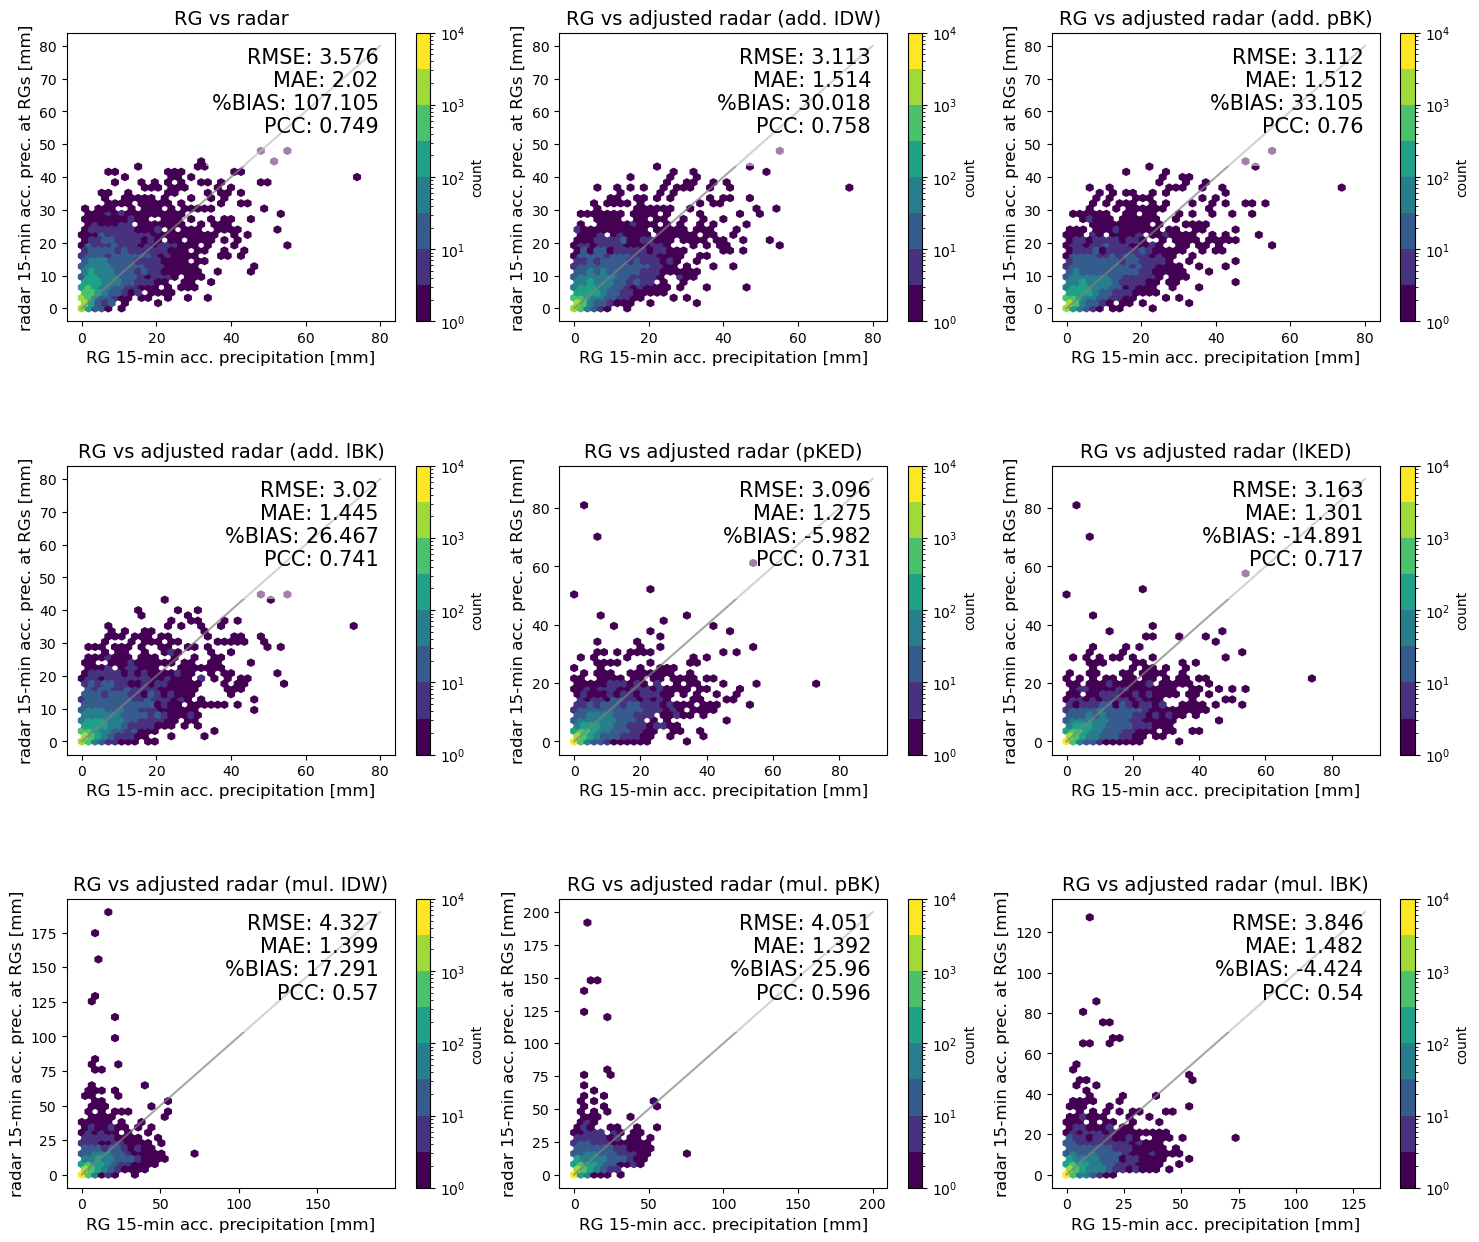

In [11]:
# fields = [[gauge name, title]]
fields = [['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK'],
          ['rainfall_add_lBK', 'rainfall_pked', 'rainfall_lked'],
          ['rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']]

titles = [['RG vs radar', 'RG vs adjusted radar (add. IDW)', 'RG vs adjusted radar (add. pBK)'],
          ['RG vs adjusted radar (add. lBK)', 'RG vs adjusted radar (pKED)', 'RG vs adjusted radar (lKED)'],
          ['RG vs adjusted radar (mul. IDW)', 'RG vs adjusted radar (mul. pBK)', 'RG vs adjusted radar (mul. lBK)']]

threshold = 0.2

fig, ax = plt.subplots(3, len(fields[0]), figsize=(6*len(fields[0]), 15)) 

for i in range(0,3):
    for j in range(0,3):

        hx = plg.validation.plot_hexbin(
            ds_gauges.rainfall_amount.values.flatten(),
            ds_gauges[fields[i][j]].values.flatten(),
            ref_thresh=0.1,
            est_thresh=0.1,
            ax=ax[i, j],
        )

        metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
            reference=ds_gauges.rainfall_amount.values.flatten(),
            estimate=ds_gauges[fields[i][j]].values.flatten(),
            ref_thresh=threshold,
            est_thresh=threshold)])

        ax[i, j].text(
            0.95, 0.95,                 
            "RMSE: "+str(round(metric.root_mean_square_error.values[0], 3))+'\n'+
            "MAE: "+str(round(metric.mean_absolute_error.values[0], 3))+'\n'+
            "%BIAS: "+str(round(metric.percent_bias.values[0], 3))+'\n'+
            "PCC: "+str(round(metric.pearson_correlation_coefficient.values[0], 3))+'\n',             
            transform=ax[i, j].transAxes,     
            ha='right', va='top',       
            fontsize=15, color='black',  
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')  
        )

        ax[i, j].set_ylabel('radar 15-min acc. prec. at RGs [mm]', fontsize=12)
        ax[i, j].set_xlabel('RG 15-min acc. precipitation [mm]', fontsize=12)
        ax[i, j].set_title(titles[i][j], fontsize=14)

plt.subplots_adjust(hspace=0.5)

In [12]:
# ALL METRICS

fields = ['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 
          'rainfall_add_lBK', 'rainfall_pked', 'rainfall_lked',
          'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']

for field in fields:
        if field == 'rainfall_radar':
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=ds_gauges.rainfall_amount.values.flatten(),
                estimate=ds_gauges[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['dataset'] = 'OpenRainER'
            metric['method'] = field
            result = metric
        else:
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=ds_gauges.rainfall_amount.values.flatten(),
                estimate=ds_gauges[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['dataset'] = 'OpenRainER'
            metric['method'] = field
            result = pd.concat([result, metric])

result.to_csv('metrics_OpenRainER.csv')

DISTANCE ANALYSIS

In [13]:
distances = np.arange(2000, 32000, 2000) # [m]
n_gauges = np.array([])
threshold = 0.2

fields = ['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 
          'rainfall_add_lBK', 'rainfall_pked', 'rainfall_lked',
          'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']

start = 0
for max_distance in distances:
    closest_neigbors = plg.spatial.get_closest_points_to_line(
        ds_cmls, ds_gauges.rainfall_amount, max_distance=max_distance, n_closest=len(ds_gauges.id.values)
    )

    closest_rgs = closest_neigbors.neighbor_id.values.flatten()
    ds_closegauges = ds_gauges.sel(id=np.unique(closest_rgs[closest_rgs!= None]))
    n_gauges = np.concat([n_gauges, np.array([len(ds_closegauges.id.values)])])

    for field in fields:

        metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
            reference=ds_closegauges.rainfall_amount.values.flatten(),
            estimate=ds_closegauges[field].values.flatten(),
            ref_thresh=threshold,
            est_thresh=threshold,
        )])
        metric['distance'] = [max_distance]
        metric['field'] = [field]

        if start == 0:
            result_metric = metric
            start += 1
        else:
            result_metric = pd.concat([result_metric, metric])

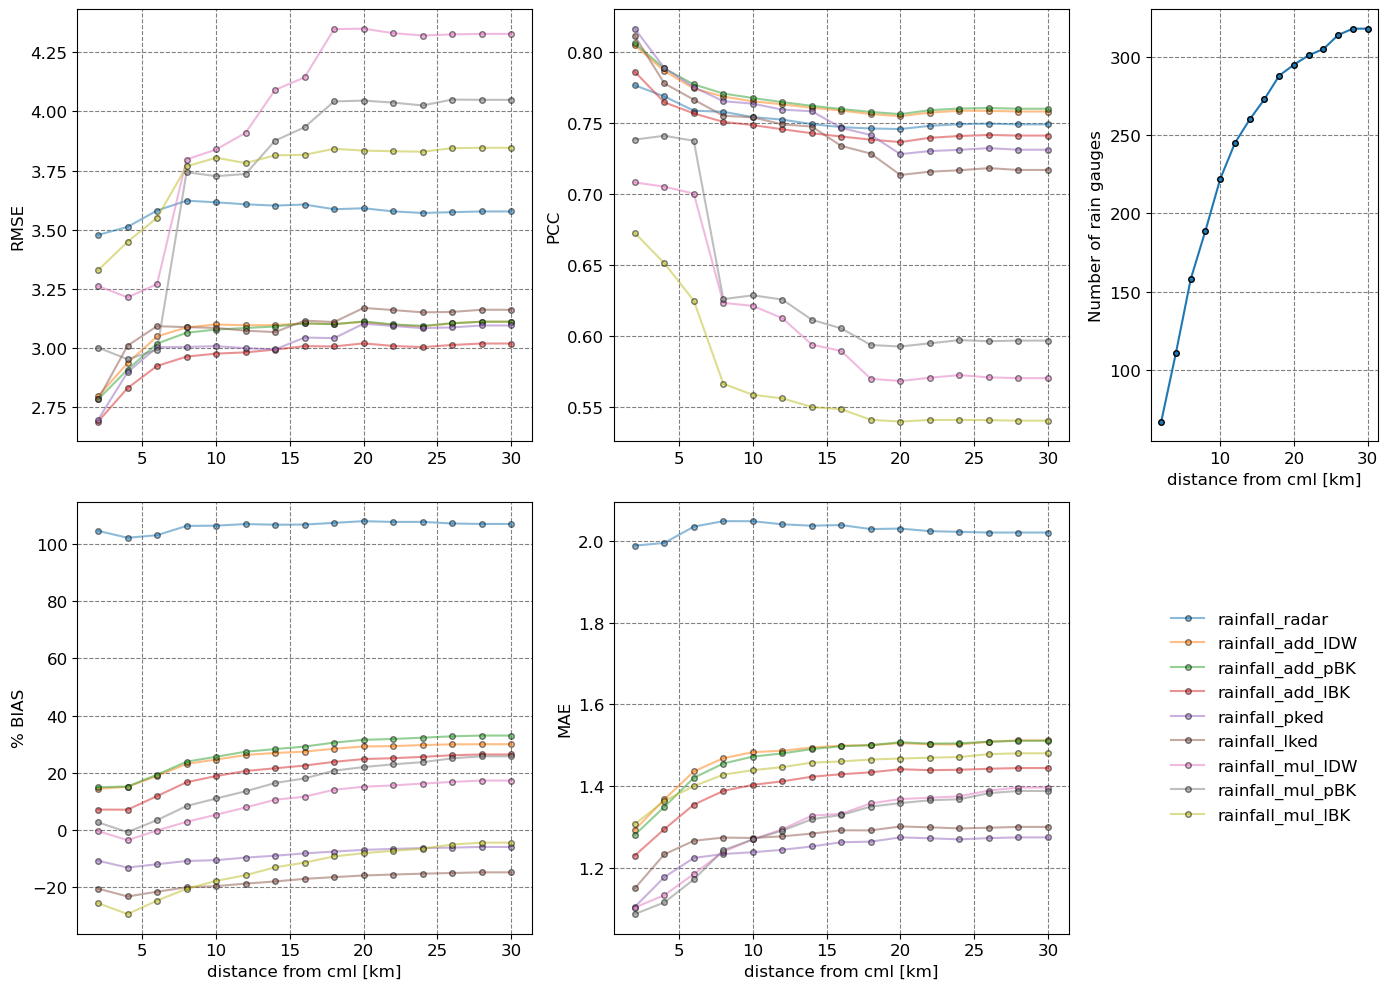

In [14]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fields = ['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 
          'rainfall_add_lBK', 'rainfall_pked', 'rainfall_lked',
          'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']

fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.5])

ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1])
ax02 = fig.add_subplot(gs[0, 2])
ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1])
legend_ax = fig.add_subplot(gs[1, 2])
legend_ax.axis('off')  

handles = []

# --- RMSE ---
for field in fields:
    result = result_metric[result_metric.field == field]
    line, = ax00.plot(result.distance/1000, result.root_mean_square_error,
                      marker='o', markeredgecolor='black', label=field, alpha=0.5, markersize=4)
    handles.append(line)

ax00.set_ylabel('RMSE', fontsize=12)
ax00.tick_params(axis='both', labelsize=12)
ax00.grid(linestyle='--', color='gray')

# --- PCC ---
for field in fields:
    result = result_metric[result_metric.field == field]
    ax01.plot(result.distance/1000, result.pearson_correlation_coefficient,
              marker='o', markeredgecolor='black', alpha=0.5, markersize=4)

ax01.set_ylabel('PCC', fontsize=12)
ax01.tick_params(axis='both', labelsize=12)
ax01.grid(linestyle='--', color='gray')

# --- Number of rain gauges ---
ax02.plot(distances/1000, n_gauges, marker='o', markersize=4, markeredgecolor='black')
ax02.set_xlabel('distance from cml [km]', fontsize=12)
ax02.set_ylabel('Number of rain gauges', fontsize=12)
ax02.tick_params(axis='both', labelsize=12)
ax02.grid(linestyle='--', color='gray')

# --- %BIAS ---
for field in fields:
    result = result_metric[result_metric.field == field]
    ax10.plot(result.distance/1000, result.percent_bias,
              marker='o', markeredgecolor='black', alpha=0.5, markersize=4)

ax10.set_xlabel('distance from cml [km]', fontsize=12)
ax10.set_ylabel('% BIAS', fontsize=12)
ax10.tick_params(axis='both', labelsize=12)
ax10.grid(linestyle='--', color='gray')

# --- MAE ---
for field in fields:
    result = result_metric[result_metric.field == field]
    ax11.plot(result.distance/1000, result.mean_absolute_error,
              marker='o', markeredgecolor='black', alpha=0.5, markersize=4)

ax11.set_xlabel('distance from cml [km]', fontsize=12)
ax11.set_ylabel('MAE', fontsize=12)
ax11.tick_params(axis='both', labelsize=12)
ax11.grid(linestyle='--', color='gray')


plt.tight_layout()

legend_ax.legend(handles, fields, loc='center', frameon=False, ncol=1, fontsize=12)

INTENSITY ANALYSIS

In [16]:
# prec_classes [lower limit, upper limit, class name (int)]
prec_classes = np.array([[0.2,2.5, '[0.2,2.5['], [2.5, 10, '[2.5,10['], [10, 50, '[10,50['], [50, 150, '>= 50']])
threshold = 0.2
fields = ['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 
          'rainfall_add_lBK', 'rainfall_pked', 'rainfall_lked',
          'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']

start = 0
for item in prec_classes:
    data = xr.where((ds_gauges.rainfall_amount >= float(item[0]))&(ds_gauges.rainfall_amount < float(item[1])), ds_gauges, np.nan) 
    for field in fields:
        if start == 0:
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=data.rainfall_amount.values.flatten(),
                estimate=data[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['class'] = [item[2]]
            metric['field'] = [field]
            ndata = data.rainfall_amount.values.flatten()
            metric['ndata'] = len(ndata[~np.isnan(ndata)])
            result = metric
            start += 1
        else:
            metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
                reference=data.rainfall_amount.values.flatten(),
                estimate=data[field].values.flatten(),
                ref_thresh=threshold,
                est_thresh=threshold,
            )]) 
            metric['class'] = [item[2]]
            metric['field'] = [field]
            ndata = data.rainfall_amount.values.flatten()
            metric['ndata'] = len(ndata[~np.isnan(ndata)])
            result = pd.concat([result, metric])

result.to_csv('intensity_analysis_OpenRainER.csv')

c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\poligrain\validation.py:192: RuntimeWarning: Mean of empty slice.
  FP_r_mean = estimate[reference_dry & estimate_wet].mean()
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\poligrain\validation.py:192: RuntimeWarning: Mean of empty slice.
  FP_r_mean = estimate[reference_dry & estimate_wet].mean()
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\poligrain\validation.py:192: RuntimeWarning: Mean of empty slice.
  FP_r_mean = estimate[reference_dry & estimate_wet].mean()
c:\Users\Utente\mambaforge\envs\BasicEnv\Lib\site-packages\numpy\_core\_methods.py:1